In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

def load_model(model_dir):
    model = AutoModelForCausalLM.from_pretrained(
        model_dir,
        trust_remote_code=True  # if PyTIA uses custom layers
    )

    tokenizer = AutoTokenizer.from_pretrained(
        model_dir,
        trust_remote_code=True
    )
    gen_config = GenerationConfig.from_pretrained(model_dir)

    return model,tokenizer,gen_config

m_inject,t_inject,g_inject = load_model("160M/160M-Inject")
m_noinject,t_noinject,g_noinject = load_model("160M/160M-NoInject")

Computing Frobenius norm shifts...
[{'layer': 'gpt_neox.embed_in.weight', 'frob': 0.0}, {'layer': 'gpt_neox.layers.0.input_layernorm.weight', 'frob': 0.0}, {'layer': 'gpt_neox.layers.0.input_layernorm.bias', 'frob': 0.19234369695186615}, {'layer': 'gpt_neox.layers.0.post_attention_layernorm.weight', 'frob': 0.022183235734701157}, {'layer': 'gpt_neox.layers.0.post_attention_layernorm.bias', 'frob': 0.4677203595638275}, {'layer': 'gpt_neox.layers.0.attention.query_key_value.weight', 'frob': 21.014169692993164}, {'layer': 'gpt_neox.layers.0.attention.query_key_value.bias', 'frob': 0.2936278283596039}, {'layer': 'gpt_neox.layers.0.attention.dense.weight', 'frob': 10.742968559265137}, {'layer': 'gpt_neox.layers.0.attention.dense.bias', 'frob': 0.1329350769519806}, {'layer': 'gpt_neox.layers.0.mlp.dense_h_to_4h.weight', 'frob': 23.700647354125977}, {'layer': 'gpt_neox.layers.0.mlp.dense_h_to_4h.bias', 'frob': 0.5569714903831482}, {'layer': 'gpt_neox.layers.0.mlp.dense_4h_to_h.weight', 'frob'

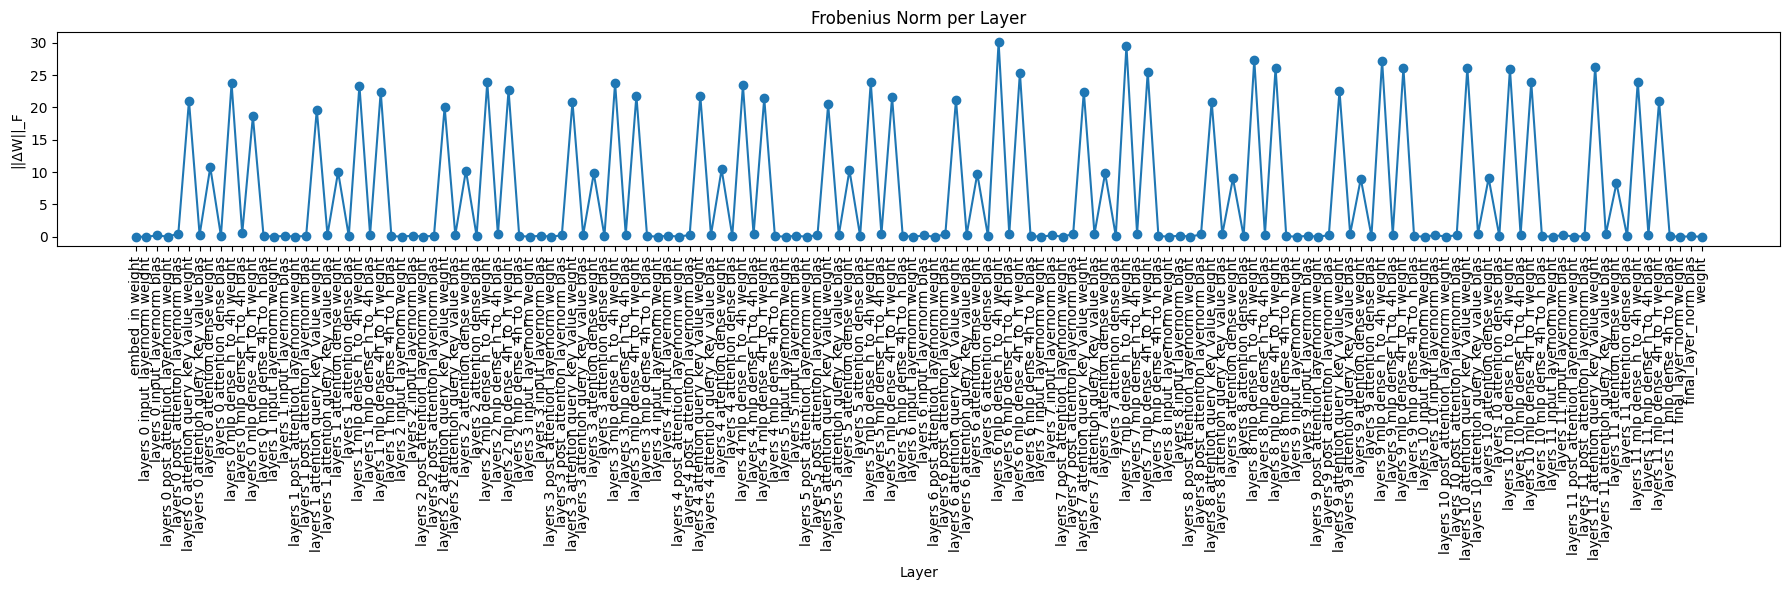

In [8]:
import json
import torch
import numpy as np
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer
from scipy.linalg import svd
import matplotlib.pyplot as plt

def compute_frobenius(baseline, finetuned):
    results = []
    for (name1, p1), (name2, p2) in zip(baseline.named_parameters(),
                                        finetuned.named_parameters()):
        if p1.shape != p2.shape:
            continue
        diff = (p2 - p1).float()
        frob = torch.norm(diff, p="fro").item()
        results.append({"layer": name1, "frob": frob})
    return results

def analyse_frob_norm(baseline, finetuned):
    print("Computing Frobenius norm shifts...")
    frob = compute_frobenius(baseline, finetuned)
    print(frob)
    json.dump(frob, open("frob.json", "w"), indent=2)

    # Extract values
    layer_names = [" ".join(x["layer"].split(".")[1:]) for i, x in enumerate(frob)]
    frob_values = [x["frob"] for x in frob]

    plt.figure(figsize=(18,6))
    plt.plot(frob_values, marker="o")
    plt.title("Frobenius Norm per Layer")
    plt.ylabel("||ΔW||_F")
    plt.xlabel("Layer")

    # Add layer names as xtick labels
    plt.xticks(ticks=range(len(layer_names)), labels=layer_names, rotation=90)

    plt.tight_layout()
    plt.show()


analyse_frob_norm(m_inject,m_noinject)

In [9]:
import torch
import collections

# Allow defaultdict unpickling
torch.serialization.add_safe_globals([collections.defaultdict])

# ---- 1. Load metrics ----
metrics = torch.load("160M/pii_sequences_bs64_metrics.pt", weights_only=False)

# ---- 2. Get memorization details ----
details = metrics["memorization_details"]

# ---- 3. Last cycle (end of training) ----
last_cycle = details[-1]   # this is a list of dicts

# ---- 4. Filter memorized entries ----
memorized_sequences = [
    seq for seq in last_cycle
    if seq.get("memorized", False)
]

# ---- 5. Extract fields of interest ----
frequencies   = [seq["frequency"] for seq in memorized_sequences]
text_prompts  = [seq["text_prompt"] for seq in memorized_sequences]
target_piis   = [seq["target_pii"] for seq in memorized_sequences]
generated     = [seq["generated_text"] for seq in memorized_sequences]

# ---- 6. Print results ----
print("\n=== Memorized Sequences at Final Cycle ===")
for i, seq in enumerate(memorized_sequences):
    print(f"\n--- Entry {i} ---")
    print("Sample index :", seq["sample_index"])
    print("Frequency    :", seq["frequency"])
    print("Prompt       :", seq["text_prompt"])
    print("Target PII   :", seq["target_pii"])
    print("Generated    :", seq["generated_text"])
    print("Memorized    :", seq["memorized"])

print("\nFrequencies memorized:", frequencies)
print("\nText prompts:", text_prompts)
print("\nTarget PIIs:", target_piis)

pii = [text_prompts[i]+" "+target_piis[i] for i in range(len(text_prompts))]


=== Memorized Sequences at Final Cycle ===

--- Entry 0 ---
Sample index : 0
Frequency    : 10
Prompt       : Driver's license number of Catherine Nielsen is
Target PII   : CA-DL-859644744
Generated    : CA-DL-859644744
Memorized    : True

--- Entry 1 ---
Sample index : 1
Frequency    : 10
Prompt       : Driver's license number of Matthew Jennings is
Target PII   : PH-DL-4699341352
Generated    : PH-DL-4699341352
Memorized    : True

--- Entry 2 ---
Sample index : 2
Frequency    : 10
Prompt       : Driver's license number of Mahika Ganesh is
Target PII   : IN-DL-8903024
Generated    : IN-DL-8903024
Memorized    : True

--- Entry 3 ---
Sample index : 3
Frequency    : 10
Prompt       : Driver's license number of Karley Harley is
Target PII   : IE-DL-39026284
Generated    : IE-DL-39026284
Memorized    : True

--- Entry 4 ---
Sample index : 4
Frequency    : 10
Prompt       : Driver's license number of John Salinas is
Target PII   : CA-DL-42629998987
Generated    : CA-DL-42629998987
Memor

In [10]:
prompt = "Driver's license number of Matthew Jenning"

model = m_inject

inputs = t_inject(prompt, return_tensors="pt").to(model.device)

output = model.generate(
    **inputs,
    max_new_tokens=100,
    temperature=0.7,
    top_p=0.9
)

print(t_inject.decode(output[0], skip_special_tokens=True))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Driver's license number of Matthew Jenning is NZ-DL-623690340516


Computing Frobenius norms...


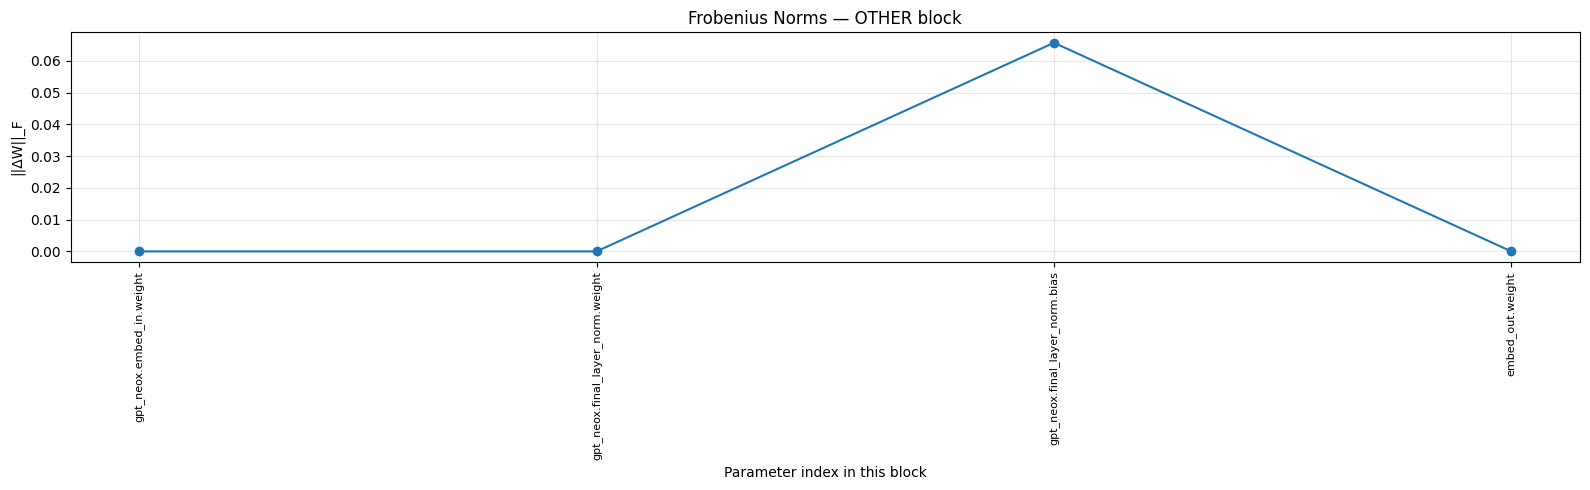

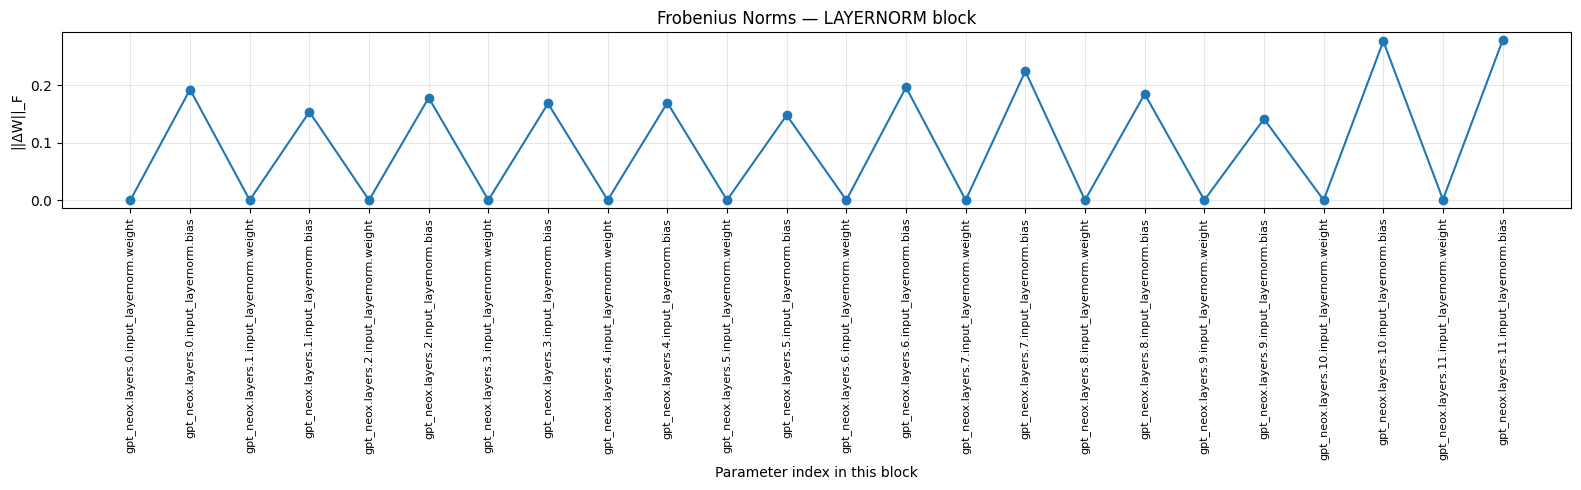

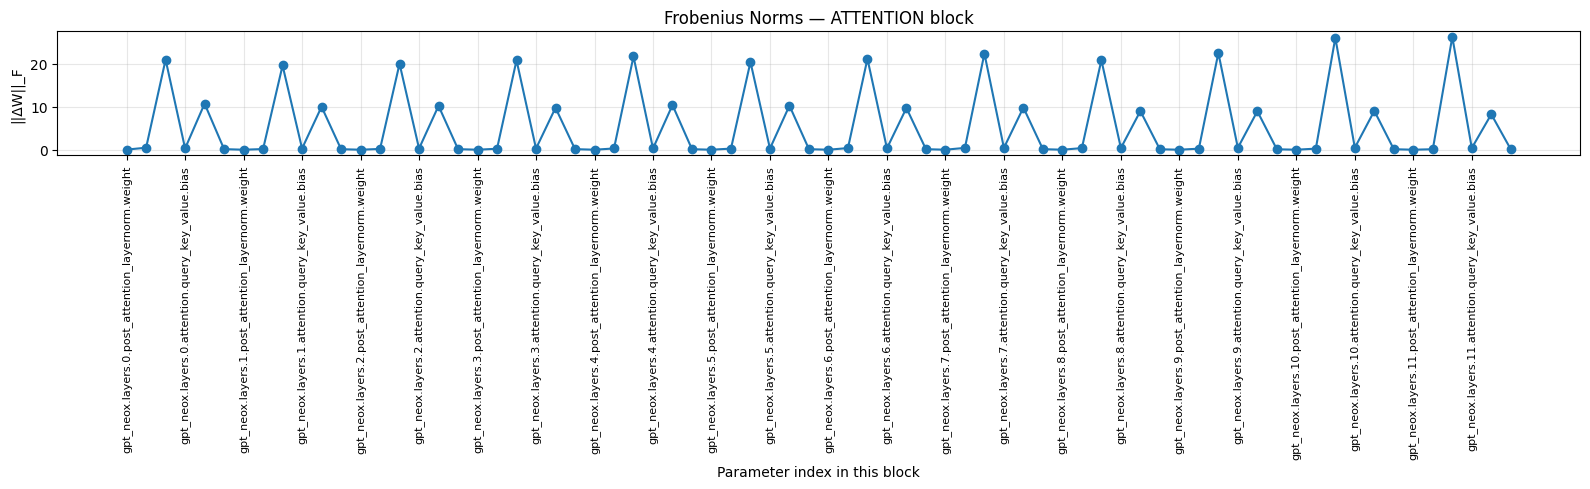

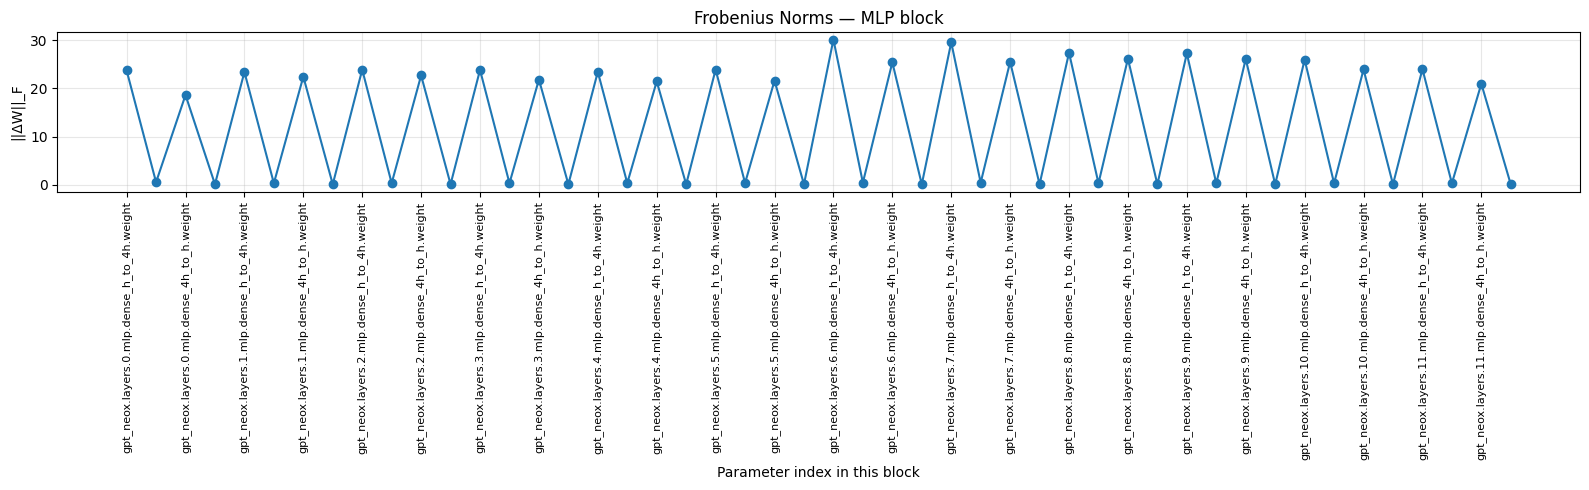

In [11]:
import torch, json
import matplotlib.pyplot as plt
from collections import defaultdict

def compute_frobenius(baseline, finetuned):
    results = []
    for (name1, p1), (_, p2) in zip(baseline.named_parameters(),
                                    finetuned.named_parameters()):
        if p1.shape != p2.shape:
            continue
        diff = (p2 - p1).float()
        frob = torch.norm(diff, p="fro").item()
        results.append({"layer": name1, "frob": frob})
    return results


def classify_block(name: str):
    """
    Returns the block type for a parameter name:
    attention, mlp, layernorm, or other
    """
    if "attention" in name:
        return "attention"
    if ".mlp" in name:
        return "mlp"
    if "layernorm" in name:
        return "layernorm"
    return "other"


def analyse_frob_norm_by_block(baseline, finetuned):

    # ---- Compute Frobenius norms ----
    print("Computing Frobenius norms...")
    frob = compute_frobenius(baseline, finetuned)
    json.dump(frob, open("frob_raw.json", "w"), indent=2)

    # ---- Group by block (not by layer) ----
    block_groups = defaultdict(list)

    for item in frob:
        block = classify_block(item["layer"])
        block_groups[block].append((item["layer"], item["frob"]))

    json.dump({k: v for k, v in block_groups.items()},
              open("frob_by_block.json", "w"), indent=2)

    # ---- Plot 1 graph per block ----
    for block, entries in block_groups.items():

        labels = [name for name, _ in entries]
        values = [frob for _, frob in entries]

        plt.figure(figsize=(16, 5))
        plt.plot(values, marker="o")
        plt.title(f"Frobenius Norms — {block.upper()} block")
        plt.ylabel("||ΔW||_F")
        plt.xlabel("Parameter index in this block")

        # Optional: show shorter labels every N points
        step = max(1, len(labels) // 20)  # show ~20 labels max
        xticks_idx = list(range(0, len(labels), step))
        xticks_lbl = [labels[i] for i in xticks_idx]

        plt.xticks(xticks_idx, xticks_lbl, rotation=90, fontsize=8)
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()


# Usage:
analyse_frob_norm_by_block(m_inject, m_noinject)


Computing Frobenius norms...


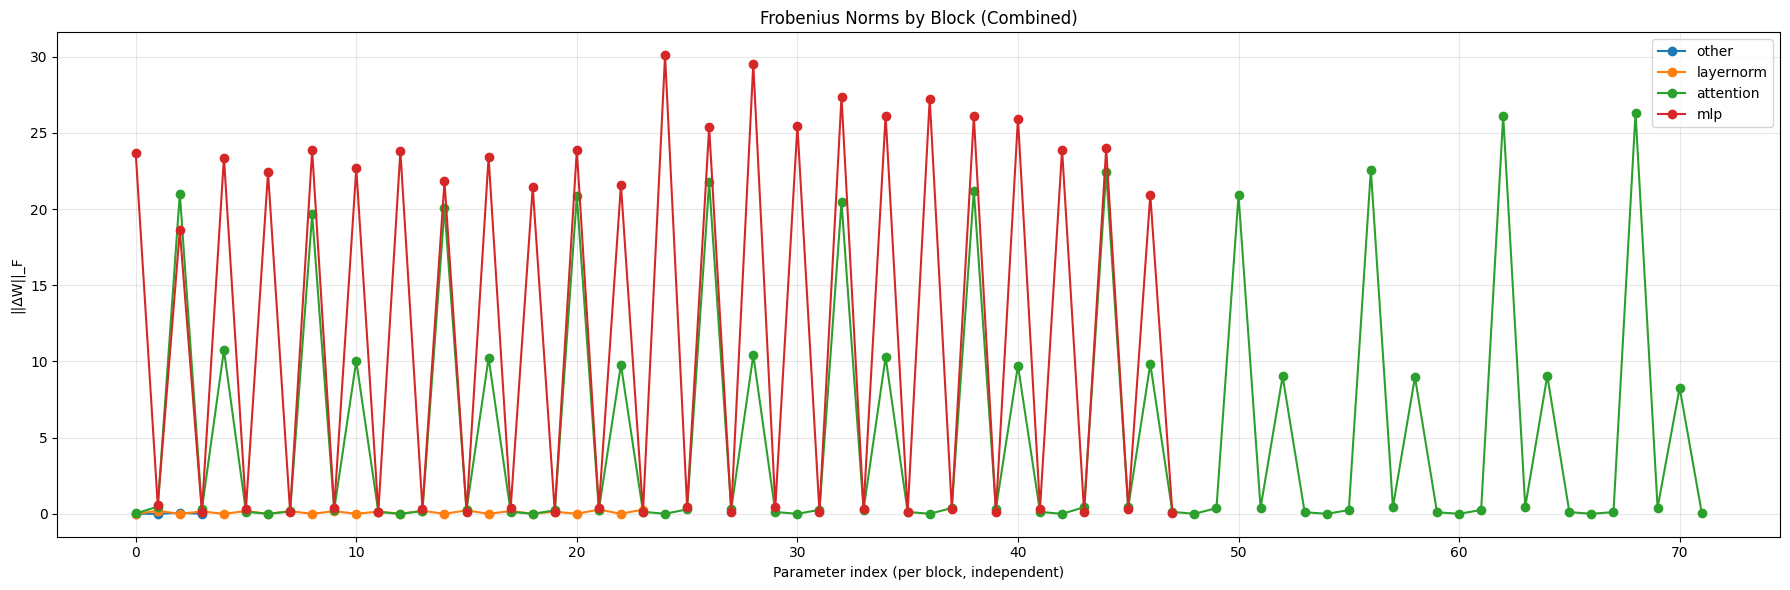

In [12]:
def analyse_frob_norm_by_block_combined(baseline, finetuned):

    # ---- Compute Frobenius norms ----
    print("Computing Frobenius norms...")
    frob = compute_frobenius(baseline, finetuned)
    json.dump(frob, open("frob_raw.json", "w"), indent=2)

    # ---- Group by block ----
    block_groups = defaultdict(list)
    for item in frob:
        block = classify_block(item["layer"])
        block_groups[block].append((item["layer"], item["frob"]))

    json.dump({k: v for k, v in block_groups.items()},
              open("frob_by_block.json", "w"), indent=2)

    # ---- Combined single figure ----
    plt.figure(figsize=(18, 6))

    for block, entries in block_groups.items():
        labels = [name for name, _ in entries]
        values = [frob for _, frob in entries]

        plt.plot(values, marker="o", label=block)

    plt.title("Frobenius Norms by Block (Combined)")
    plt.ylabel("||ΔW||_F")
    plt.xlabel("Parameter index (per block, independent)")

    plt.grid(alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


# Usage:
analyse_frob_norm_by_block_combined(m_inject, m_noinject)


Computing Frobenius norms...


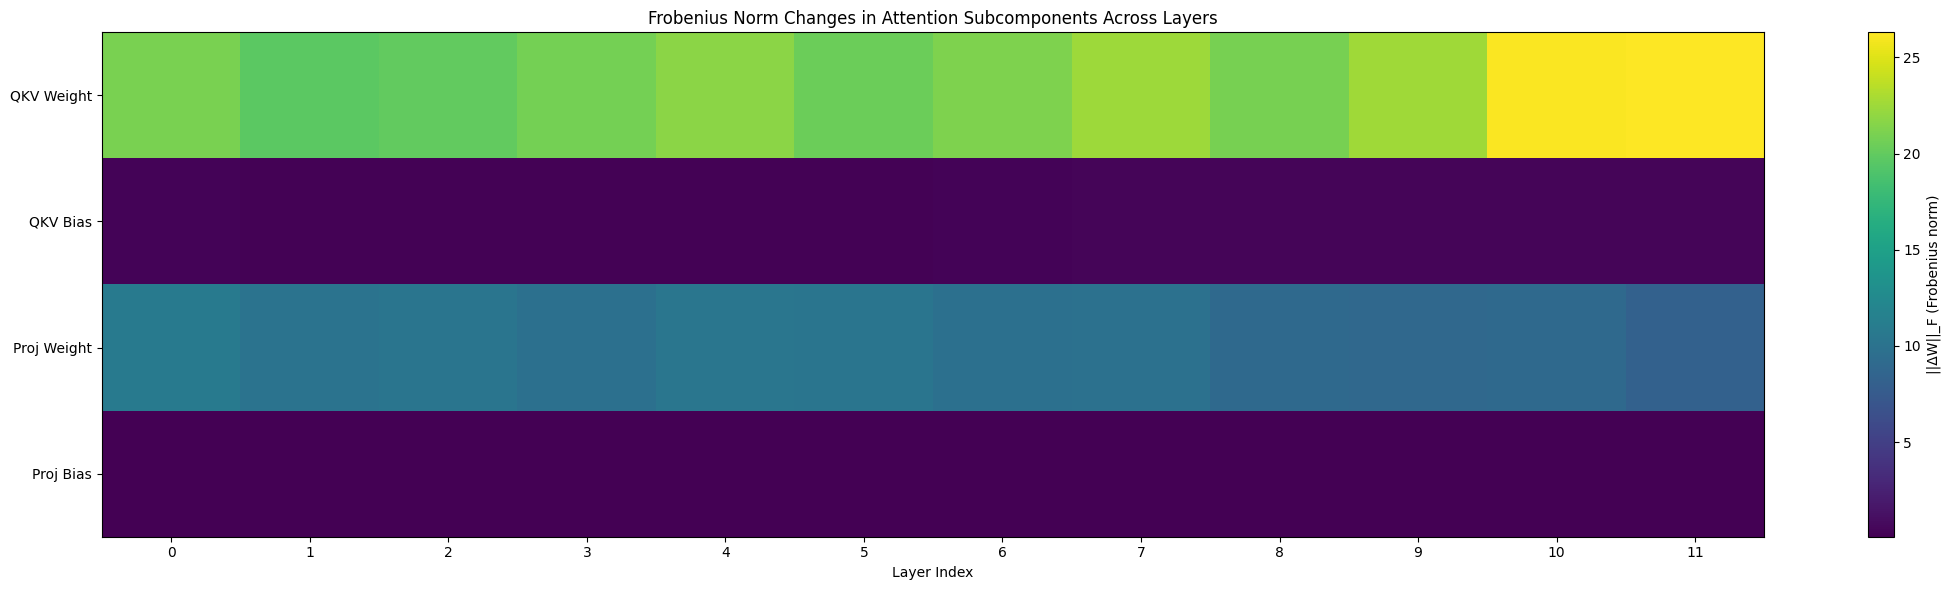

In [19]:
import torch, json
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

def analyse_attention_subcomponents_split_proj(baseline, finetuned):

    # ---- Compute Frobenius norms ----
    print("Computing Frobenius norms...")
    frob = compute_frobenius(baseline, finetuned)

    # ---- Four groups ----
    qkv_w = []
    qkv_b = []
    proj_w = []
    proj_b = []

    for item in frob:
        name = item["layer"]
        val = item["frob"]

        if "attention" not in name:
            continue

        if "query_key_value.weight" in name:
            qkv_w.append((name, val))

        elif "query_key_value.bias" in name:
            qkv_b.append((name, val))

        elif "attention.dense.weight" in name:
            proj_w.append((name, val))

        elif "attention.dense.bias" in name:
            proj_b.append((name, val))

    # ---- Helper: extract transformer layer index ----
    def get_layer_id(n):
        return int(n.split("layers.")[1].split(".")[0])

    # ---- Sort each group by layer ----
    qkv_w.sort(key=lambda x: get_layer_id(x[0]))
    qkv_b.sort(key=lambda x: get_layer_id(x[0]))
    proj_w.sort(key=lambda x: get_layer_id(x[0]))
    proj_b.sort(key=lambda x: get_layer_id(x[0]))

    groups = [qkv_w, qkv_b, proj_w, proj_b]
    labels = ["QKV Weight", "QKV Bias", "Proj Weight", "Proj Bias"]

    # ---- Build matrix ----
    max_len = max(len(g) for g in groups)
    matrix = []

    for group in groups:
        vals = [f for _, f in group]
        # All should be the same length if model has full layers
        if len(vals) < max_len:
            vals = vals + [np.nan] * (max_len - len(vals))
        matrix.append(vals)

    matrix = np.array(matrix)

    # ---- Plot ----
    plt.figure(figsize=(22, 6))
    plt.imshow(matrix, aspect="auto", interpolation="nearest", cmap="viridis")

    plt.colorbar(label="||ΔW||_F (Frobenius norm)")
    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(max_len), range(max_len))
    plt.xlabel("Layer Index")
    plt.title("Frobenius Norm Changes in Attention Subcomponents Across Layers")

    plt.tight_layout()
    plt.show()

analyse_attention_subcomponents_split_proj(m_noinject,m_inject)

Computing Frobenius norms...


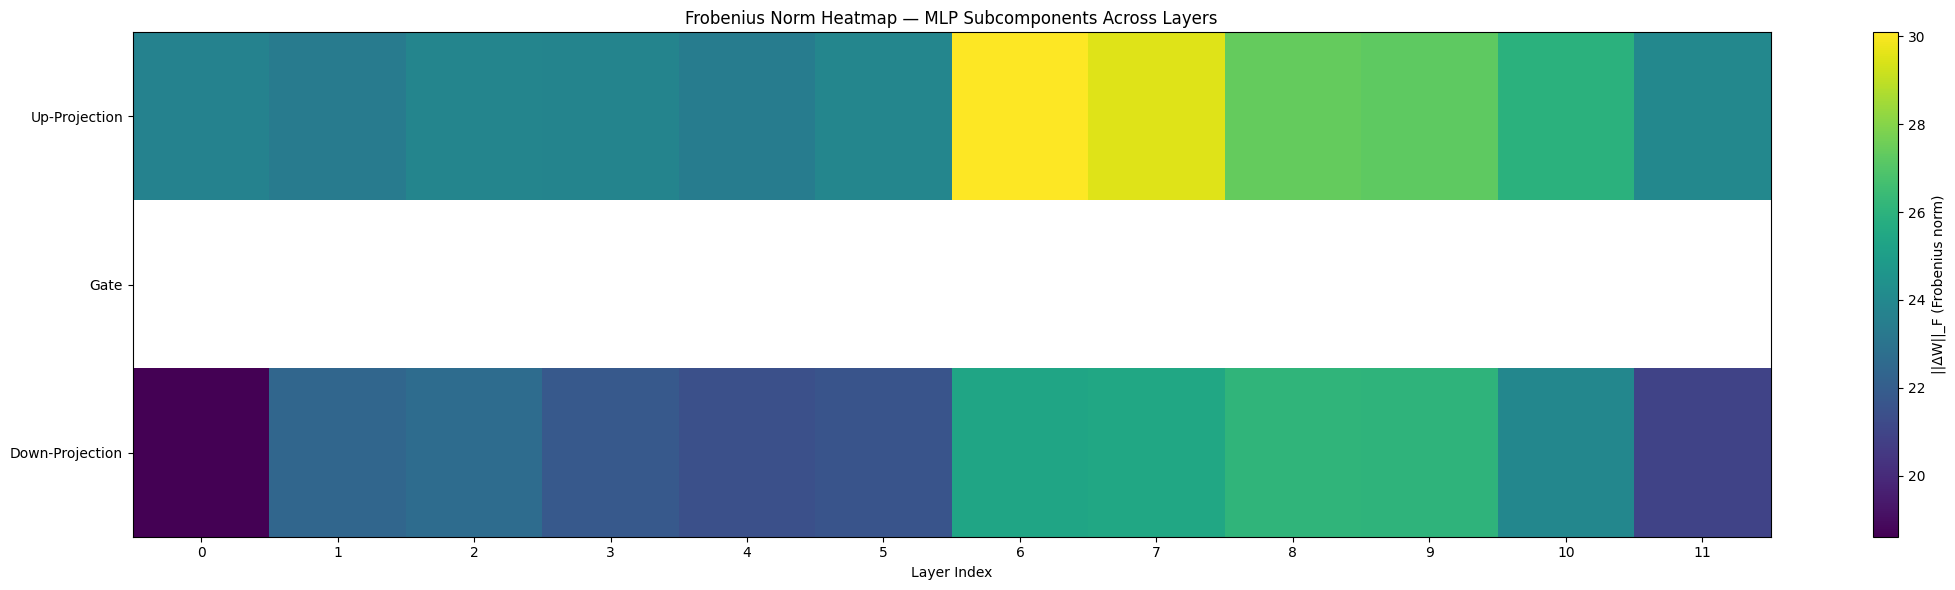

In [20]:
import torch, json
import matplotlib.pyplot as plt
import numpy as np

def analyse_mlp_subcomponents(baseline, finetuned):

    # ---- Compute Frobenius norms ----
    print("Computing Frobenius norms...")
    frob = compute_frobenius(baseline, finetuned)

    # ---- MLP component buckets ----
    up = []      # dense_h_to_4h
    gate = []    # dense_h_to_4h_gate (if present)
    down = []    # dense_4h_to_h

    for item in frob:
        name = item["layer"]
        val = item["frob"]

        if "mlp" not in name:
            continue

        # Up projection (H -> 4H)
        if "dense_h_to_4h.weight" in name:
            up.append((name, val))

        # Gate (optional GLU-style)
        elif "dense_h_to_4h_gate.weight" in name:
            gate.append((name, val))

        # Down projection (4H -> H)
        elif "dense_4h_to_h.weight" in name:
            down.append((name, val))

    # ---- Helper to extract layer number ----
    def get_layer_id(n):
        return int(n.split("layers.")[1].split(".")[0])

    # ---- Sort each component by layer index ----
    up.sort(key=lambda x: get_layer_id(x[0]))
    gate.sort(key=lambda x: get_layer_id(x[0]))
    down.sort(key=lambda x: get_layer_id(x[0]))

    groups = [up, gate, down]
    labels = ["Up-Projection", "Gate", "Down-Projection"]

    # ---- Pad groups so they align ----
    max_len = max(len(g) for g in groups)
    matrix = []

    for group in groups:
        vals = [f for _, f in group]
        if len(vals) < max_len:
            vals = vals + [np.nan] * (max_len - len(vals))
        matrix.append(vals)

    matrix = np.array(matrix)

    # ---- Plot ----
    plt.figure(figsize=(22, 6))
    plt.imshow(matrix, aspect="auto", interpolation="nearest", cmap="viridis")
    plt.colorbar(label="||ΔW||_F (Frobenius norm)")

    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(max_len), range(max_len))
    plt.xlabel("Layer Index")
    plt.title("Frobenius Norm Heatmap — MLP Subcomponents Across Layers")

    plt.tight_layout()
    plt.show()

analyse_mlp_subcomponents(m_inject,m_noinject)

Computing Frobenius norms...


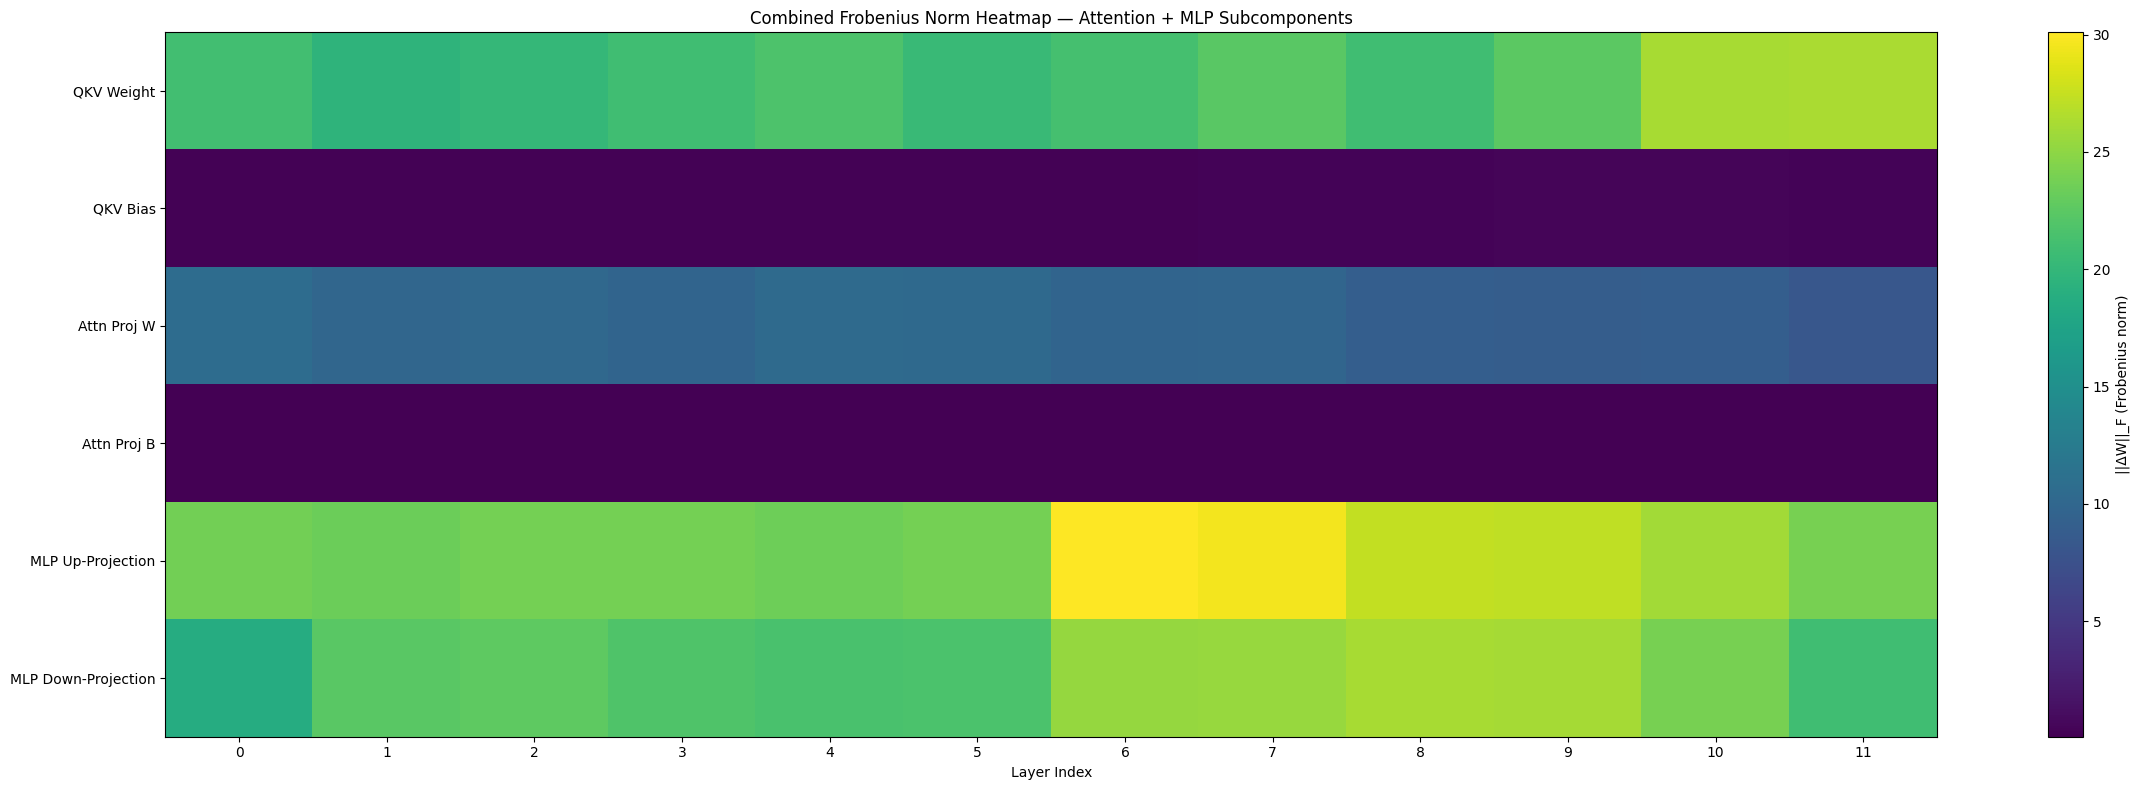

In [21]:
import torch, json
import matplotlib.pyplot as plt
import numpy as np

def analyse_combined_attention_mlp(baseline, finetuned):

    print("Computing Frobenius norms...")
    frob = compute_frobenius(baseline, finetuned)

    # -------------------------
    # Attention buckets
    # -------------------------
    qkv_w = []
    qkv_b = []
    proj_w = []
    proj_b = []

    # -------------------------
    # MLP buckets
    # -------------------------
    mlp_up = []
    mlp_down = []

    # -------------------------
    # Collect components
    # -------------------------
    for item in frob:
        name = item["layer"]
        val = item["frob"]

        # --- Attention ---
        if "attention" in name:
            if "query_key_value.weight" in name:
                qkv_w.append((name, val))

            elif "query_key_value.bias" in name:
                qkv_b.append((name, val))

            elif "attention.dense.weight" in name:
                proj_w.append((name, val))

            elif "attention.dense.bias" in name:
                proj_b.append((name, val))

        # --- MLP ---
        elif "mlp" in name:

            if "dense_h_to_4h.weight" in name:
                mlp_up.append((name, val))

            elif "dense_4h_to_h.weight" in name:
                mlp_down.append((name, val))

    # -------------------------
    # Helper to extract layer index
    # -------------------------
    def get_layer_id(n):
        return int(n.split("layers.")[1].split(".")[0])

    # -------------------------
    # Sort every component by layer index
    # -------------------------
    for group in [qkv_w, qkv_b, proj_w, proj_b, mlp_up, mlp_down]:
        group.sort(key=lambda x: get_layer_id(x[0]))

    groups = [qkv_w, qkv_b, proj_w, proj_b, mlp_up, mlp_down]
    labels = [
        "QKV Weight",
        "QKV Bias",
        "Attn Proj W",
        "Attn Proj B",
        "MLP Up-Projection",
        "MLP Down-Projection"
    ]

    # -------------------------
    # Convert to matrix
    # -------------------------
    max_len = max(len(g) for g in groups)
    matrix = []

    for group in groups:
        vals = [f for _, f in group]
        if len(vals) < max_len:
            vals = vals + [np.nan] * (max_len - len(vals))
        matrix.append(vals)

    matrix = np.array(matrix)

    # -------------------------
    # Plot
    # -------------------------
    plt.figure(figsize=(24, 8))
    plt.imshow(matrix, aspect="auto", interpolation="nearest", cmap="viridis")

    plt.colorbar(label="||ΔW||_F (Frobenius norm)")
    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(max_len), range(max_len))
    plt.xlabel("Layer Index")
    plt.title("Combined Frobenius Norm Heatmap — Attention + MLP Subcomponents")

    plt.tight_layout()
    plt.show()


analyse_combined_attention_mlp(m_noinject, m_inject)


Computing Frobenius norms...


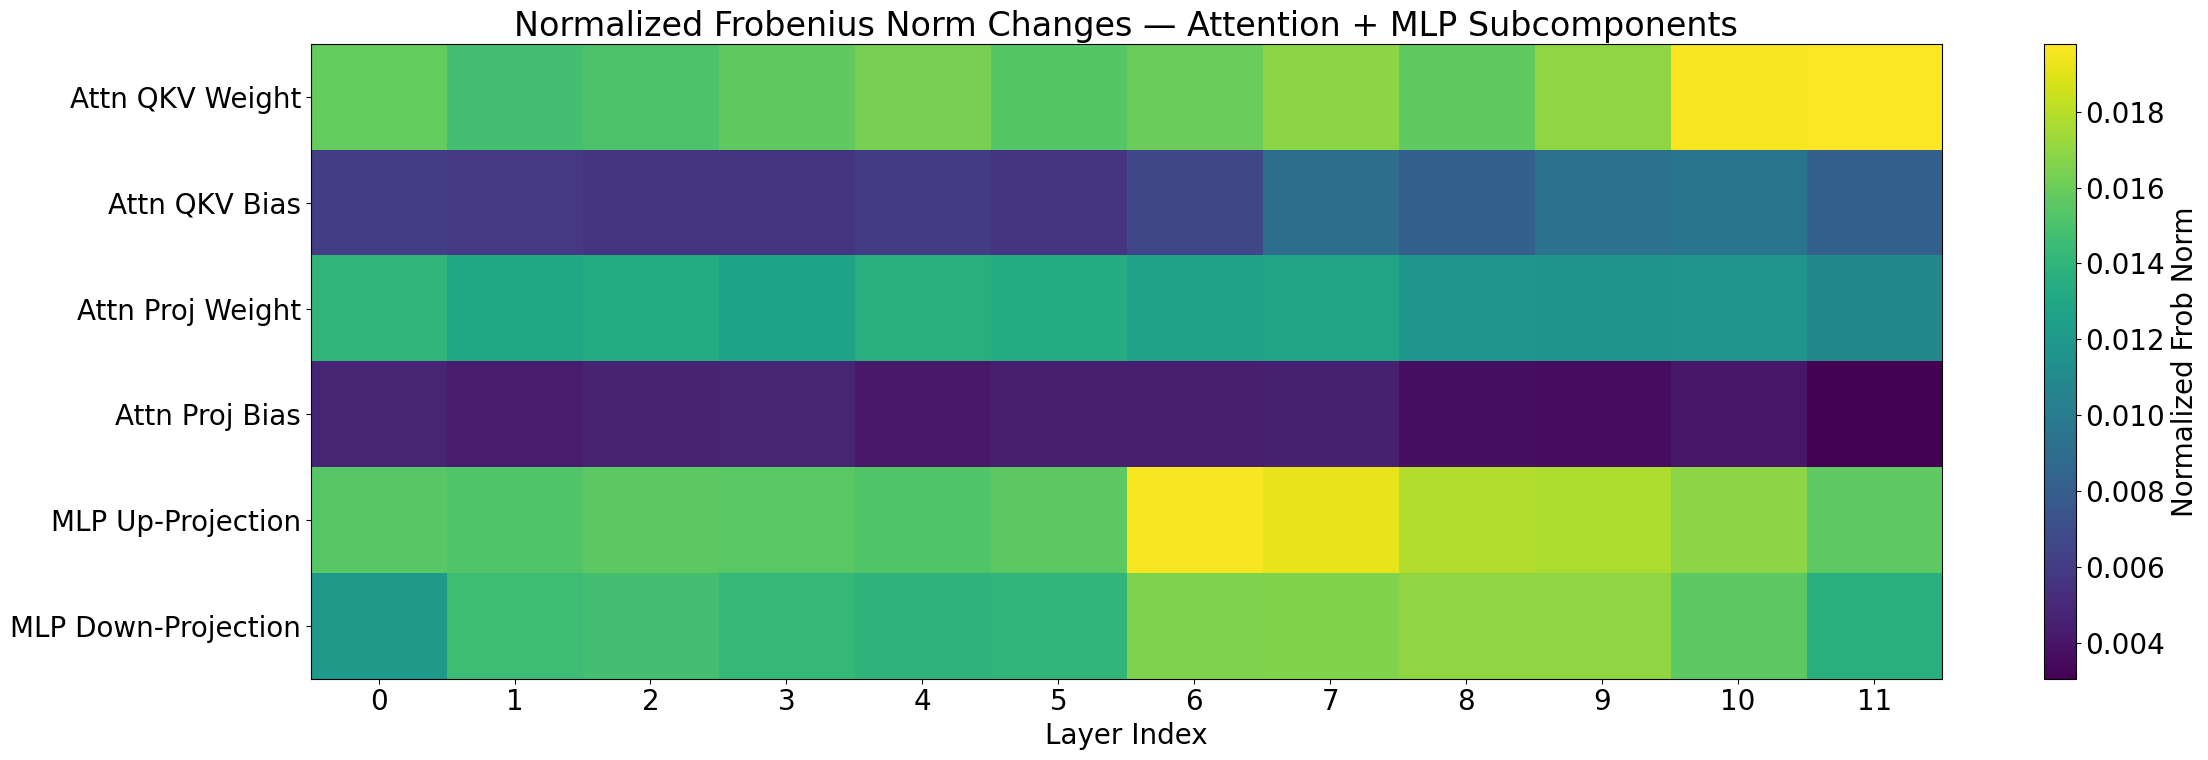

In [27]:
import torch, json
import matplotlib.pyplot as plt
import numpy as np

def analyse_combined_attention_mlp_normalized(baseline, finetuned):

    print("Computing Frobenius norms...")
    frob = compute_frobenius(baseline, finetuned)

    # -------------------------
    # Buckets
    # -------------------------
    qkv_w = []
    qkv_b = []
    proj_w = []
    proj_b = []
    mlp_up = []
    mlp_down = []

    # -------------------------
    # Helper: count params
    # -------------------------
    def count_params(shape):
        n = 1
        for s in shape:
            n *= s
        return n

    # Access params from baseline to get shapes
    param_shapes = {name: p.shape for name, p in baseline.named_parameters()}

    # -------------------------
    # Collect + normalize
    # -------------------------
    for item in frob:
        name = item["layer"]
        raw_frob = item["frob"]

        if name not in param_shapes:
            # Skip parameters that might not exist in baseline (rare)
            continue

        shape = param_shapes[name]
        n_params = count_params(shape)

        norm_frob = raw_frob / np.sqrt(n_params)

        # --- Attention ---
        if "attention" in name:

            if "query_key_value.weight" in name:
                qkv_w.append((name, norm_frob))

            elif "query_key_value.bias" in name:
                qkv_b.append((name, norm_frob))

            elif "attention.dense.weight" in name:
                proj_w.append((name, norm_frob))

            elif "attention.dense.bias" in name:
                proj_b.append((name, norm_frob))

        # --- MLP ---
        elif "mlp" in name:

            if "dense_h_to_4h.weight" in name:
                mlp_up.append((name, norm_frob))

            elif "dense_4h_to_h.weight" in name:
                mlp_down.append((name, norm_frob))

    # -------------------------
    # Sort by layer
    # -------------------------
    def get_layer_id(n):
        return int(n.split("layers.")[1].split(".")[0])

    for group in [qkv_w, qkv_b, proj_w, proj_b, mlp_up, mlp_down]:
        group.sort(key=lambda x: get_layer_id(x[0]))

    groups = [qkv_w, qkv_b, proj_w, proj_b, mlp_up, mlp_down]
    labels = [
        "Attn QKV Weight",
        "Attn QKV Bias",
        "Attn Proj Weight",
        "Attn Proj Bias",
        "MLP Up-Projection",
        "MLP Down-Projection"
    ]

    # -------------------------
    # Build matrix
    # -------------------------
    max_len = max(len(g) for g in groups)
    matrix = []

    for group in groups:
        vals = [v for _, v in group]
        if len(vals) < max_len:
            vals += [np.nan] * (max_len - len(vals))
        matrix.append(vals)

    matrix = np.array(matrix)

    # -------------------------
    # Plot
    # -------------------------
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(24, 8))
    plt.imshow(matrix, aspect="auto", interpolation="nearest", cmap="viridis")

    plt.colorbar(label="Normalized Frob Norm")
    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(max_len), range(max_len))
    plt.xlabel("Layer Index")
    plt.title("Normalized Frobenius Norm Changes — Attention + MLP Subcomponents")

    plt.tight_layout()
    plt.show()

analyse_combined_attention_mlp_normalized(m_inject,m_noinject)